<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/week4_RNN_Seq_NLP_denis_lemarchand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IVADO/MILA DEEP LEARNING SCHOOL
# Spring 2021
# Tutorial: Sequences and Natural Language Processing.

## Authors

Mirko Bronzi <mirko.bronzi@mila.quebec>

Pierre Luc Carrier <pierre.luc.carrier@mila.quebec>

Jeremy Pinto <jeremy.pinto@mila.quebec>

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

### Translation to English: 

Laurent Charlin <lcharlin@gmail.com>

# Preface

This tutorial introduces the fundamental concepts that underlie recurrent neural networks (RNN et LSTM) and Transformers, using two example tasks.

The first task builds and compares an RNN model, an LSTM model, and a Transformer model.

In the second task we will use Hugging Face pre-trained models to perform a translation task.

---
# Initialization 

To ensure that this tutorial runs properly on the Colab environment, we must install a few libraries using the `pip` utility. 

To begin, ensure that you are "connected" to the notebook ( check for "✓ CONNECTED" at the top right of your window). Then execute the cell below by selecting it and clicking `shift`+`Enter`. You will see the version of the installed `PyTorch` package and whether or not a GPU is available on this runtime session.

In [9]:
# Install HuggingFace/Transformers and HuggingFace/Datasets and sacrebleu (for
# the error metric)
!pip install transformers==3.5.0 datasets==1.1.2 sacrebleu
!pip install torch==1.7.0

import copy
import gc
import math
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModelWithLMHead, Trainer, TrainingArguments

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Setting the seed to a fixed value can be helpful in reproducing results
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("PyTorch version: ", torch.__version__)
print("GPU available: {}".format(use_gpu))

print("Using the following GPU type: {}".format(torch.cuda.get_device_name(0)))
print('The GPU memory is {:.2f} GB'.format(torch.cuda.get_device_properties(0).total_memory * 1e-9))

PyTorch version:  1.7.0
GPU available: True
Using the following GPU type: Tesla P100-PCIE-16GB
The GPU memory is 17.07 GB


---
# Task 1: Adding numbers


## Objective

Our goal is to build a model capable of adding an arbitrary sequence of numbers. It is all in all a fairly simple task (any pocket calculator can trivially do it) yet it will demonstrate that this procedure can be learned from data. Further, we will use it to learn how to work on data based on sequences, and to compare RNNs, LSTMs and Transformers.



## Dataset

Our data is composed of a sequence of numbers in input that we want want to sum.

In the following image, you can see a visual intuition (where we have 4 elements in the input sequence):

![Texte alternatif…](https://github.com/mila-iqia/ivado-mila-dl-school-2021/blob/main/tutorials/images/task.png?raw=true)

If we consider just one example, the input to our model will be a tensor $\mathbf x = \left[x_{1}, x_{2}, \dots, x_{seq\_len}\right]$ of length $seq\_len$, and a target $y$ given by:

\begin{align}  
y=\sum_{j=1}^{seq\_len}x_j,
\end{align}

where $j$ indexes the element in the sequence.

So far we have one dimension for the input data $x$ (the sequence), and just one scalar in output (the sum to predict). We can say that:
* $x\ dim = [seq\_len]$
* $y\ dim = [1]$ (just one scalar)

As you have seen in the other tutorials though, we always work with multiple examples. So, we need to add another dimension, that we will call the batch dimension (sometimes also called example dimension), that contain $batch\_size$ example. In general, we add this dimension in the first position in the tensors. So we have:
* $x\ dim = [batch\_size, seq\_len]$
* $y\ dim = [batch\_size]$

This is enough to model our data. But we need to make sure that the amount/order of the tensor's dimensions is the one expected by the API that we will use later. To this end, we need to add another dimension, which we will call data dimension, with size $data\_dim$ (which in our task will always be equal to 1). In fact, in our task all the elements are scalar (every element in the input sequence is a scalar, and every element at the output is a scalar representing the sum of the input elements), but in general we work with vectors (for example, think about NLP, and word embeddings).

So, to deal with this, we need to add the aforementioned data dimension. In our task this dimension will have size 1 (so, basically a scalar), but we still have to add it so that the API will work correctly.

So, the final dimensions for our data are:
* $x\ dim = [batch\_size, seq\_len, data\_dim]$
* $y\ dim = [batch\_size, data\_dim]$

### Generating our dataset

It will be useful to have a function that can generate random datasets of `n_samples` sequences each of length `seq_length`. To do so we will rely on the function [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint). The function `generate_data` takes as input the following arguments:
- **n_samples** (int): number of examples to generate.
- **seq_len** (int): length of each sequence in the examples.
- **input_dim** (int, optional): dimension of the input data. Default: 1.
- **xmin** (float, optional): minimum possible value in the sequence. Default: -100.
- **xmax** (float, optional): maximum possible value in the sequence. Default: 100.

It returns a tuple of two elements corresponding respectively to:
- **X** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times seq\_len \times input\_dim$ representing a set of `n_samples` sequences, each of length `seq_len`. The elements of the sequences are of dimension `input_dim`, that is, they belong to ${\mathbb R}^{input\_dim}$.
- **Y** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times  input\_dim$ representing the corresponding sum of the elements for each sequence in `X`.

In [ ]:
def generate_data(n_samples, seq_len, input_dim=1, xmin=-100, xmax=100):
    """Generate tensors X and Y within the [xmin, xmax] interval.
    
    Args : 
      n_samples: int, number of sequences to generate
      seq_len: int, length of each sequence
      input_dim: int, dimension of the input data
      xmin: minimum possible value in the sequence
      xmax: maximum possible value in the sequence
    
    Returns: n_samples sequence of numbers X and associated targets Y in this
             format torch.Tensor where X.shape = (n_samples, seq_len, 1)
             and Y.shape = (n_samples, 1).
    """
    X = torch.randint(xmin, xmax+1, (n_samples, seq_len, input_dim))
    Y = X.sum(dim=1)
    #Y = X.prod(dim=1)
    
    return X, Y

The following piece of code shows an example of how to use the `generate_data` function.

In this example, we are generating 1000 sequences of numbers $\in \mathbb R$ (i.e, `input_dim` is set to 1), each one of lenght 4.

In [ ]:
n_samples = 1000
seq_len = 4
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Tensor dimensions X = {}, Y = {}".format(X.shape, Y.shape))
print("Data example:\n\tinput {}\n\ttarget: {}".format(X[0,:,0], Y[0,0]))

Tensor dimensions X = torch.Size([1000, 4, 1]), Y = torch.Size([1000, 1])
Data example:
	input tensor([ 71,  40, -84,  81])
	target: 108


### Standardizing data

To help the training of our model we will first standardize the input data such that it has, overall, `mean` 0 and standard deviation (`stdev`) 1. To do so we simply calculate the mean and std of our data and then substract the former and divide by the latter. In addition, we will store these two values for later usage. This standardization often speeds up learning.

**Note**: since we generated our data from a uniform distribution, the standard deviation should be close to $\frac{(xmax-xmin)}{\sqrt{12}}$ while the mean should be close to $\frac{(xmax+xmin)}{2}$.

The following function performs such a standardization operation. It takes as input a tensor **X** (of shape $n\_samples \times seq\_len \times input\_dim$) we would like to standardize and returns a tuple of 4 elements corresponding respectively to:
- **Xs**: the standardized version of X, of shape $n\_samples \times seq\_len \times input\_dim$
- **Ys**: the new sum of the sequences of Xs, of shape $n\_samples \times input\_dim$
- **mean**: the mean of X, float.
- **stdev**: the stdandard deviation of X, float.

In [ ]:
def standardize(X):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      Ys: torch.Tensor, the (new) sum of Xs.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()
    mean = torch.mean(X)
    std = torch.std(X)
    Xs = (X-mean) / std
    Ys = Xs.sum(dim=1)
    #Ys = Xs.prod(dim=1)

    return Xs, Ys, mean, std


An example of how to use the above defined function is shown below. Here, after generating the data using the `generate_data` function, we use the `standardize` function to standardize it.

In [ ]:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
example_before = X[0,:,0]
Xs, Ys, mean, std = standardize(X)
print("mean = {:.4f}, std = {:.4f}".format(mean, std))
print('example before standardization - X: {} => y: {}'.format(X[0,:,0], Y[0,:]),
      '\nexample after standardization - X: {} => y: {}'.format(Xs[0,:,0], Ys[0,:])
)
print(Xs[0])
print(Xs[999])
print(Xs[-1])

mean = 0.5472, std = 58.2220
example before standardization - X: tensor([-55,  70, -84,  -9]) => y: tensor([-78]) 
example after standardization - X: tensor([-0.9541,  1.1929, -1.4522, -0.1640]) => y: tensor([-1.3773])
tensor([[-0.9541],
        [ 1.1929],
        [-1.4522],
        [-0.1640]])
tensor([[ 0.2826],
        [-0.3014],
        [-1.0228],
        [-0.0094]])
tensor([[ 0.2826],
        [-0.3014],
        [-1.0228],
        [-0.0094]])


## RNN implementation 

We will define our RNN using the following PyTorch class [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN). For more details regarding the implementation of this class, we suggest this [tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#example-2-recurrent-net). Once initialized, it takes input data `X` of shape `(seq_len, batch_size, input_dim)` (recall that we will use `input_dim=1` for our task). We then will add a linear layer ([torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)) to transform the last hidden recurrent state to have the same dimensionality as `Y` which has size `(batch_size, input_dim)` (again `input_dim=1`).

Note that here we are using `batch_size` instead of `n_examples`. Indeed, when we train (so, when we perform a training step), we will feed the model with a subset of the training data (i.e., a batch with size `batch_size`), and not all the data in the training size (which has size `n_examples`).

See the following figure for a visual intuition about the model that we will implement now:

![Texte alternatif…](https://github.com/mila-iqia/ivado-mila-dl-school-2021/blob/main/tutorials/images/rnn_task.png?raw=true)


The following methods are to be completed:
* The `__init__()` method to define the different layers of our model. 
* The `forward()` method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*).

**NB**: 

* Remember that **only** the last output of the RNN is needed, i.e., `output[-1]` (see $h_3$ in the figure above).

* You must ensure that the dimensions of your input data `X` matches what is required by the RNN class [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN). 

  **Hint:** this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.

### Exercise 1

Complete this piece of code to implement the above described network using the [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hidden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [ ]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn_layer = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)
        self.print_debug_flag = False

    def print_debug(self,text,var):
      if self.print_debug_flag == True:
        print(text,var)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        self.print_debug('x:',x)

        x = torch.transpose(x, 0, 1)

        self.print_debug('x\':',x)

        output, hidden = self.rnn_layer(x)

        self.print_debug('hidden:',hidden)
        self.print_debug('output:',output)
        self.print_debug('output[-1]:',output[-1])
        self.print_debug('linear_layer(output):',self.linear_layer(output))
        self.print_debug('linear_layer(output[-1]):',self.linear_layer(output[-1]))

        output = self.linear_layer(output)
        pred = output[-1]
        self.print_debug('pred:',pred)

        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)
        
# x has size of (n_samples=batch_size, seq_len, input_dim)
# The RNN's input must be of size (seq_len, batch_size, input_dim)
print(Xs.shape)
Xs_t = torch.transpose(Xs, 0, 1)
print(Xs_t.shape)
print(Ys[0])
print(y_pred[0])

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])
torch.Size([50, 4, 1])
torch.Size([4, 50, 1])
tensor([0.2733])
tensor([0.1505], device='cuda:0', grad_fn=<SelectBackward>)


## LSTM implementation

We will now implement an LSTM using this PyTorch class [torch.nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). Just like with the RNN, we will need to add a linear layer ([torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)) to transform the last recurrent state of our LSTM to have the same dimensions of our target `Y` which has size `(batch_size, input_dim)` (with `input_dim=1` as above).

For a visual intuition, you can look at the following image:
![Texte alternatif…](https://github.com/mila-iqia/ivado-mila-dl-school-2021/blob/main/tutorials/images/rnn_task.png?raw=true)

To define the architecture of our LSTM, the following methods are to be completed:
* The `__init__()` method to define the different layers of our model.
* The `forward()` method method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*).

**NB**: 

* Remember that **only** the last output of the LSTM is needed, i.e., `output[-1]` (see $h_3$ in the figure above).

* You must ensure that the dimensions of your input data `X` matches what is required by the LSTM class [torch.nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). 
   
   **Hint**: this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.


### Exercise 2

Complete this piece of code to implement the above described network using the [torch.nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hidden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [ ]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        self.lstm_layer = torch.nn.LSTM(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        x = torch.transpose(x, 0, 1)
        output, (hidden, cn) = self.lstm_layer(x)
        
        output = self.linear_layer(output)

        pred = output[-1]
        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the LSTM model
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_lstm = model_lstm.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the model to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_lstm(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)
print(Ys[0])
print(y_pred[0])

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])
tensor([-0.4111])
tensor([-0.1749], device='cuda:0', grad_fn=<SelectBackward>)


## Transformer implementation

We will now implement a Transformer.

First of all, let's notice that we do not need a full Transformer. In fact, the Transformer is a sequence-to-sequence architecture that takes a sequence in input, and produces a sequence in output.
Here, we do not need to produce a sequence in output, just one single value.
So, we can use only the Transformer encoder (note that this is the same approach as in BERT).

As "usual", we will also use a linear projection to obtain the final output:

![Texte alternatif…](https://github.com/mila-iqia/ivado-mila-dl-school-2021/blob/main/tutorials/images/transformer_task.png?raw=true)

Before implementing the model, a few things to mention:
- The Pytorch Transformer implementation does not allow us to specify an input size different from the hidden size. To deal with this, we will project the input, with dimensions `(seq_len, batch_size, input_dim)` to `(seq_len, batch_size, hidden_size)`. This part of the code is already given to you.
- The Transformer requires positional embeddings in order to understand the position of the element in the sequence. This part of the code is given to you. See [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) for more details.
- The Self-Attention used in the Transformer encoder is bidirectional. As a consequence, each hidden state $h_j$ can see the full sequence. So, differently from the RNN and LSTM case, we will not be forced to take the last hidden state.

Since the implementation of Positional Encodings is beyond the scope of this exercise, we make use of the class PositionalEncoding defined below, reused as-is from the PyTorch tutorials.


In [ ]:
######################################################################
# ``PositionalEncoding`` module injects some information about the
# relative or absolute position of the tokens in the sequence. The
# positional encodings have the same dimension as the embeddings so that
# the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
# different frequencies.
#
# Source : https://pytorch.org/tutorials/beginner/transformer_tutorial.html
#
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

As with the RNN and LSTM approaches, we will need to add a linear layer to transform the last output of the Transformer to have the same dimensions of our target `Y`, which has size `(batch_size, output_dim)` (with `output_dim=1` as above).

To define the architecture of our Transformer, the following methods are to be completed:
* The `__init__()` method to define the different layers of our model.
* The `forward()` method method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*).

**NB**: 

* The Transformer Self-Attention is bi-directional. As a consequence, we do not need to take the last hidden state. Indeed, it is actually more common to take the first hidden state `output[0]`. This is also what happens with BERT.

* You must ensure that the dimensions of your input data `X` matches what is required by the Transformer encoder class (see the comments in the code below for a hint). Same as before, this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful to change the dimension order if needed.

### Exercise 3

Complete this piece of code to implement the above described network using the [torch.nn.TransformerEncoderLayer()](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) and [torch.nn.TransformerEncoder()](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html) classes. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hidden_size**: the size to which to project the input data before feeding into the Transformer encoder
- **n_heads**: the number of attention heads in each Transformer encoder layer
- **n_layers**: the number of layers in the Transformer encoder.

In [ ]:
class TransformerLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_heads, n_layers):
        super(TransformerLinear, self).__init__()

        self.linear_inp_to_hid = nn.Linear(input_dim, hidden_size)
        #self.pos_encoder = PositionalEncoding(input_dim)
        self.pos_encoder = PositionalEncoding(hidden_size)

        # ma partie
        trans_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=hidden_size, nhead=n_heads)
        self.trans_layer = torch.nn.TransformerEncoder(encoder_layer=trans_encoder_layer, num_layers=n_layers)

        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)

    def forward(self, x):
        # Project input and inject positional encodings
        x = self.linear_inp_to_hid(x)
        x = self.pos_encoder(x)

        # ma partie
        # Invoke transformer and produce prediction
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # Note: the input to the Transformer must be of size (seq_len, batch_size, hidden_size)
        x = torch.transpose(x, 0, 1)
        output = self.trans_layer(x)

        output = self.linear_layer(output)
        
        pred = output[0]
        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_heads = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the Transformer model
model_transformer = TransformerLinear(input_dim, output_dim, hidden_size, n_heads, n_layers)

# Transfer the model to the proper device
model_transformer = model_transformer.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_transformer_weights = copy.deepcopy(model_transformer.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the model to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_transformer(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])


## Splitting the data into train / validation / test

We will use PyTorch's DataLoader objects to efficiently manipulate our data. 

We will generate 25,000 sequences and use 80% of those for training, 10% for validation, and 10% for testing. We can use the following functions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) and [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to prepare our Dataloader.

Note we will use the following values:

* `seq_len = 50` 
* `batch_size = 64`
* `n_samples = 25000`

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 50
batch_size = 64

# generate the data:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)

# and standardize it:
Xs, Ys, mean, std = standardize(X)

# split it
train_val_index = round(0.8*n_samples)
val_test_index = round(0.9*n_samples)

xtrain, ytrain = Xs[:train_val_index], Ys[:train_val_index]
xvalid, yvalid = Xs[train_val_index:val_test_index], Ys[train_val_index:val_test_index]
xtest, ytest = Xs[val_test_index:], Ys[val_test_index:]

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size, shuffle=True)

# prepare the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(xvalid, yvalid), batch_size)

# prepare the dataloader for the test dataset
test_loader = DataLoader(TensorDataset(xtest, ytest), batch_size)

## Training the RNN-based model

Several cost functions and optimizers can be used from PyTorch. 

### Exercise 4: Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that it will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="https://pytorch.org/docs/master/generated/torch.optim.SGD.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.001.

Complete the following piece of code by defining the MSE loss function and the `get_optimizer()` function.

In [ ]:
learning_rate = 0.001

# Define the loss function
loss_fun = torch.nn.MSELoss()

# Define the Optimizer
def get_optimizer(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return optimizer

### Exercise 5: Define the training loop

To train our model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*. We will use `n_epoch = 25`.

Complete the following piece of code with the instructions correponding to the related comments.

In [ ]:
# Define function to encapsulate main training loop
def train_model(model, init_weights, optimizer):

    since = time.time()

    train_loss_history = []
    valid_loss_history = []

    n_epoch = 25

    model.load_state_dict(init_weights)

    print("Start training")

    for epoch in range(n_epoch):
        
        train_loss = 0
        train_n_iter = 0
        
        # Set model to train mode
        model.train()
        torch.set_grad_enabled(True)
        
        # Iterate over train data
        for x, y in train_loader:  

            
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)

            # Zero the gradient buffer
            optimizer.zero_grad()
            
            # Perform the Forward operation
            outputs = model(x)
            
            # Calculate the loss using the loss function
            loss = loss_fun(outputs, y)
            
            # Perform the Backward operation
            loss.backward()
            
            # Perform the Optimization step
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            train_n_iter += 1
        
        valid_loss = 0
        valid_n_iter = 0
        
        # Set model to evaluate mode
        model.eval()
        with torch.no_grad():
        
            # Iterate over valid data
            for x, y in valid_loader:  
            
                # Put tensors on device (GPU when available)
                x = x.to(device)
                y = y.to(device)
            
                # Perform the Forward operation
                outputs = model(x)
                
                # Calculate the loss using the loss fun function
                loss = loss_fun(outputs,y)
            
                # Statistics
                valid_loss += loss.item()
                valid_n_iter += 1
        
        train_loss_history.append(train_loss / train_n_iter)
        valid_loss_history.append(valid_loss / valid_n_iter)


        print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
              .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

    time_elapsed = time.time() - since

    print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return train_loss_history, valid_loss_history

In [ ]:
# Perform training of the RNN model
optimizer_rnn = get_optimizer(model_rnn)
loss_history = train_model(model_rnn, init_rnn_weights, optimizer_rnn)

# Save loss history for later
rnn_train_loss_history, rnn_valid_loss_history = loss_history

Start training
Epoch  1 | Training loss = 50.30871 | Validation loss = 49.42506 
Epoch  2 | Training loss = 46.12318 | Validation loss = 32.06780 
Epoch  3 | Training loss = 41.77172 | Validation loss = 44.16628 
Epoch  4 | Training loss = 49.23018 | Validation loss = 49.50582 
Epoch  5 | Training loss = 48.04225 | Validation loss = 42.61745 
Epoch  6 | Training loss = 45.83536 | Validation loss = 49.78109 
Epoch  7 | Training loss = 49.50174 | Validation loss = 49.26810 
Epoch  8 | Training loss = 49.45164 | Validation loss = 48.14670 
Epoch  9 | Training loss = 45.26024 | Validation loss = 49.82820 
Epoch 10 | Training loss = 50.46843 | Validation loss = 49.81689 
Epoch 11 | Training loss = 50.45155 | Validation loss = 49.83420 
Epoch 12 | Training loss = 50.41161 | Validation loss = 49.70825 
Epoch 13 | Training loss = 50.13404 | Validation loss = 49.08748 
Epoch 14 | Training loss = 49.46110 | Validation loss = 42.89134 
Epoch 15 | Training loss = 48.29693 | Validation loss = 49.90

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

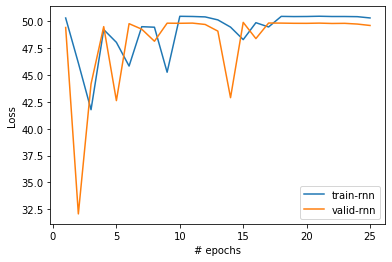

In [ ]:
# Plot training and validation curve
n_epoch = 25
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Training the LSTM-based model

### Exercise 6: Training the LSTM

Complete the following piece of code to train the LSTM model.

**Hint** : Reuse the functions `get_optimizer()` and `train_model()` that you completed previously in the section "Training the RNN-based model".


In [ ]:
# Perform training of the LSTM model
optimizer_lstm = get_optimizer(model_lstm)
loss_history = train_model(model_lstm, init_lstm_weights, optimizer_lstm)

# Save loss history for later
lstm_train_loss_history, lstm_valid_loss_history = loss_history

Start training
Epoch  1 | Training loss = 50.47188 | Validation loss = 49.78364 
Epoch  2 | Training loss = 50.38882 | Validation loss = 49.75794 
Epoch  3 | Training loss = 50.36766 | Validation loss = 49.71842 
Epoch  4 | Training loss = 50.31687 | Validation loss = 49.64402 
Epoch  5 | Training loss = 50.14621 | Validation loss = 49.46873 
Epoch  6 | Training loss = 49.79792 | Validation loss = 48.75149 
Epoch  7 | Training loss = 42.71740 | Validation loss = 59.59067 
Epoch  8 | Training loss = 40.52608 | Validation loss = 40.77352 
Epoch  9 | Training loss = 19.04354 | Validation loss = 11.69523 
Epoch 10 | Training loss = 11.98177 | Validation loss = 7.38035 
Epoch 11 | Training loss = 8.64535 | Validation loss = 5.76371 
Epoch 12 | Training loss = 6.46202 | Validation loss = 5.11600 
Epoch 13 | Training loss = 4.42483 | Validation loss = 9.24462 
Epoch 14 | Training loss = 4.14930 | Validation loss = 4.30009 
Epoch 15 | Training loss = 3.18004 | Validation loss = 4.02454 
Epoch 

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

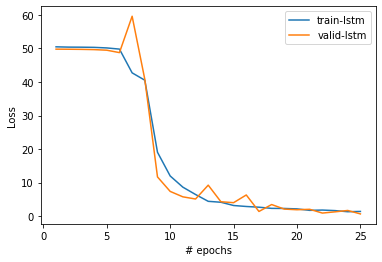

In [ ]:
# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Training the Transformer-based model

### Exercise 7: Training the Transformer

Complete the following piece of code to train the Transformer model.

**Hint** : Reuse the functions `get_optimizer()` and `train_model()` that you completed previously in the section "Training the RNN-based model".


In [ ]:
# Perform training of the Transformer model
optimizer_transformer = get_optimizer(model_transformer)
loss_history = train_model(model_transformer, init_transformer_weights, optimizer_transformer)

# Save loss history for later
transformer_train_loss_history, transformer_valid_loss_history = loss_history

Start training
Epoch  1 | Training loss = 32.55574 | Validation loss = 7.67797 
Epoch  2 | Training loss = 5.96531 | Validation loss = 2.13174 
Epoch  3 | Training loss = 3.50216 | Validation loss = 2.77777 
Epoch  4 | Training loss = 2.60333 | Validation loss = 1.90458 
Epoch  5 | Training loss = 2.04037 | Validation loss = 0.85759 
Epoch  6 | Training loss = 1.75962 | Validation loss = 0.48694 
Epoch  7 | Training loss = 1.53579 | Validation loss = 1.73232 
Epoch  8 | Training loss = 1.32881 | Validation loss = 0.63654 
Epoch  9 | Training loss = 1.18393 | Validation loss = 0.29320 
Epoch 10 | Training loss = 1.07512 | Validation loss = 0.34598 
Epoch 11 | Training loss = 1.03263 | Validation loss = 0.33932 
Epoch 12 | Training loss = 0.98257 | Validation loss = 0.16888 
Epoch 13 | Training loss = 0.87758 | Validation loss = 0.40801 
Epoch 14 | Training loss = 0.90498 | Validation loss = 0.62895 
Epoch 15 | Training loss = 0.83180 | Validation loss = 0.21360 
Epoch 16 | Training loss

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

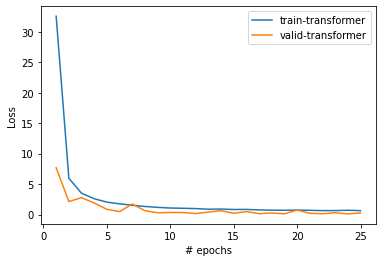

In [ ]:
# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, transformer_train_loss_history, label='train-transformer')
plt.plot(xaxis, transformer_valid_loss_history, label='valid-transformer')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Analyzing the results

We will now compare the RNN, the LSTM and the Transformer using their performance on train/validation and test sets.

### Comparing training curves


Compare the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

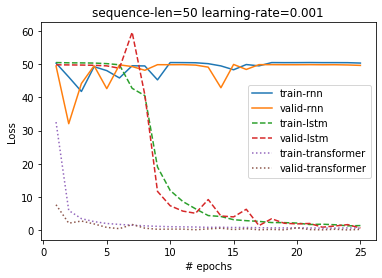

In [ ]:
# Plot training and validation curve
xaxis = range(1, n_epoch + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.plot(xaxis, transformer_train_loss_history, label='train-transformer', linestyle='dotted')
plt.plot(xaxis, transformer_valid_loss_history, label='valid-transformer', linestyle='dotted')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.title('sequence-len='+str(seq_len)+' learning-rate='+str(learning_rate))
plt.legend()
plt.show()

**Questions**

1. Which network works best according to validation? Why is that? 
2. Assume you want to increase the gap between the RNN and LSTM performances. Or between the LSTM and Transformer performances. How would you modify the data?

-------------
I've found that the task is very hard for an RNN model. Decrease  sequence lenght (seq len) make the model more confortable with the task. LSTM more robust on seq len. Transformer very robust on seq len and is learning faster.



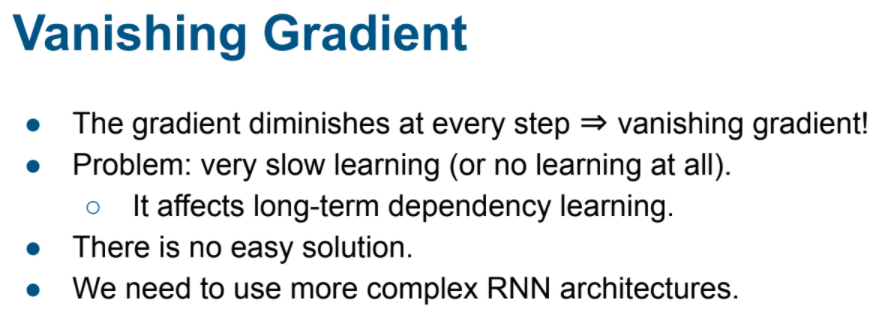

### Evaluating test error

In the following cell, we evaluate and print the mean squared error on the test set for the models.

In [ ]:
# Put sequence data on device (GPU when available)
xtest = xtest.to(device)

# Put target data on device (GPU when available)
ytest = ytest.to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(xtest)

# Predict the value of the sequence data using the LSTM-based model
ypred_lstm = model_lstm(xtest)

# Predict the value of the sequence data using the Transformer-based model
ypred_transformer = model_transformer(xtest)

# Compute the loss of the RNN-based model using the loss function
loss_test_rnn = loss_fun(ypred_rnn, ytest)

# Compute the loss of the LSTM-based model using the loss function
loss_test_lstm = loss_fun(ypred_lstm, ytest)

# Compute the loss of the Transformer-based model using the loss function
loss_test_transformer = loss_fun(ypred_transformer, ytest)


print(f"The RNN's test mean squared error is {float(loss_test_rnn):2.3f}")
print(f"The LSTM's test mean squared error is {float(loss_test_lstm):2.3f}")
print(f"The Transformer's test mean squared error is {float(loss_test_transformer):2.3f}")

The RNN's test mean squared error is 51.012
The LSTM's test mean squared error is 0.609
The Transformer's test mean squared error is 0.248


### Further exploring the results

To gain insights into our models we will inspect their outputs (i.e., their predictions before calculating the cost). To help us we will define a `print_sequence()` function. 

This function takes as input the tensors X and Y, samples a particular entry (sequence), prints the entry and prints the absolute difference between the true Y and the predicted Y.

Recall that we have standardized our examples. For these visualizations we wish to use the original data pre-standardization. To do so, we use `mean` and `std` such that $xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$.


In [ ]:
def print_sequence(X, Y, idx=0):
    """Print ground truth sum and predicted values.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: index of the sequence (entry) to use.
    """
    xs = X[idx].numpy()
    ys = Y[idx].numpy()

    x_string = ' + '.join([str(int(x)) for x in xs])
            
    print("Sequence: ", x_string)
    print("Prediction: ", str(ys[0]))
    print("Ground truth value: ", str(np.sum(xs))) #np.sum(xs)
    diff = abs(np.sum(xs)-ys[0]) #np.sum(xs)
    print(f"Absolute error between X[{idx}] et Y[{idx}]: {diff}")

In [ ]:
def print_mean_abs_error(X, Y):
    xs = X.numpy()
    ys = Y.numpy()

    diff = abs(np.sum(xs,axis=1)-ys)
    print(f"Absolute mean error between X[:] et Y[:] = {np.mean(diff)}")

In the following cell, we use the model to predict some sums.

In [ ]:
xtest = xtest.cpu()
ypred_rnn = ypred_rnn.cpu()

# Unstandardize  xtest
xtest_unstd = xtest*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + seq_len*mean

# sample a random number from the examples above:
idx = np.random.randint(len(ytest))

print("")
print("Example RNN:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)
print_mean_abs_error(xtest_unstd.detach(), ypred_unstd.detach())

xtest = xtest.cpu()
ypred_lstm = ypred_lstm.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_lstm*std + seq_len*mean

print("")
print("Example LSTM:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)
print_mean_abs_error(xtest_unstd.detach(), ypred_unstd.detach())

xtest = xtest.cpu()
ypred_transformer = ypred_transformer.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_transformer*std + seq_len*mean

print("")
print("Example Transformer:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)
print_mean_abs_error(xtest_unstd.detach(), ypred_unstd.detach())


Example RNN:

Sequence:  -30 + 42 + -40 + -91 + -56 + 94 + -40 + -82 + 29 + 35 + -28 + 93 + 12 + -54 + 27 + -38 + -52 + -65 + -4 + 71 + -25 + 56 + 27 + -60 + -23 + 9 + -56 + -41 + 66 + 12 + 10 + -21 + -16 + 21 + 0 + 23 + 19 + -45 + 84 + 3 + 69 + -44 + 59 + -3 + -69 + 58 + 16 + -85 + 86 + -74
Prediction:  -24.405523
Ground truth value:  -121.0
Absolute error between X[1479] et Y[1479]: 96.59447479248047
Absolute mean error between X[:] et Y[:] = 331.1069641113281

Example LSTM:

Sequence:  -30 + 42 + -40 + -91 + -56 + 94 + -40 + -82 + 29 + 35 + -28 + 93 + 12 + -54 + 27 + -38 + -52 + -65 + -4 + 71 + -25 + 56 + 27 + -60 + -23 + 9 + -56 + -41 + 66 + 12 + 10 + -21 + -16 + 21 + 0 + 23 + 19 + -45 + 84 + 3 + 69 + -44 + 59 + -3 + -69 + 58 + 16 + -85 + 86 + -74
Prediction:  -120.51015
Ground truth value:  -121.0
Absolute error between X[1479] et Y[1479]: 0.4898529052734375
Absolute mean error between X[:] et Y[:] = 33.521949768066406

Example Transformer:

Sequence:  -30 + 42 + -40 + -91 + -56 

**Bonus exercise**

* Redo the above analysis but instead of summing the input values try other operations (e.g., product).
* Compare the performance of the RNN, LSTM and Transformer for sequences of different length (i.e., change `seq_len`).

## On sequences of different length

In this part of the tutorial, we have focused on a synthetic dataset in which all input sequences have the same length. Unfortunately, this won't always be the case.

In and of themselves, the models used in this section (RNN, LSTM, Transformer) are not hardcoded to expect a specific sequence length so they can actually handle variable-sized inputs. This means that training/predicting on a single example and then doing the same on another single example with a different sequence length isn't a problem.

The difficulty occurs if we still want to take advantage of the additional computational efficiency that minibatch training offers. In such a scenario, we might end up having examples of different lengths in the same minibatch.

In some scenarios, it is sufficient to simply pad all the elements in a minibatch to the length of the longuest sequence. This is the case for the task of summing numbers that we have worked on in this part; we can simply pad sequences with zeroes without changing the meaning of the inputs or changing the appropriate labels. For instance, input sequences :
```
[1, 2, 3]
[4, 5]
```
could be padded into the following 2x3 minibatch input : 
```
[[1, 2, 3],
 [4, 5, 0]]
```
Simple enough!

In most scenarios of interest, however, padding is not sufficient. For natural language processing, for instance, padding shorter sentences by adding words to them may change the very meaning of those sequences, changing the prediction that a model would make. In such a setting, we need to use padding but we also use another technique called "masking". Masking is a way to make a model (and the training process in general) ignore some of the elements in the inputs.

Since this is a bit more involved, it falls outside of the scope of the current tutorial but feel free to look at the following [blog post](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e) for an example of how to do this in PyTorch for an LSTM model.

Fortunately, most DL frameworks offer mechanisms to make padding and masking easier. Some, like HuggingFace, can even handle all of the details internally, without any user input. 

## Cleaning up GPU memory

Before moving on to the next task, run the cell below to delete the three models we have experimented with (and their respective optimizers) to free up the memory that has been allocated on the GPU for them.

The K80 GPUs (the standard GPUs on Colab) have a limited amount of memory so it is important to do this clean up step other wise we won't have enough GPU memory for task 2.

Alternatively, you could restart the notebook, run only the initialization cell at the very beginning, and then move on directly to task 2.

In [ ]:
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# Delete Pytorch models
del model_rnn
del model_lstm
del model_transformer

# Delete Pytorch optimizers
del optimizer_rnn
del optimizer_lstm
del optimizer_transformer

# Clean up zombie tensors that might still exist
gc.collect()

# Return now-unused GPU memory to the system
torch.cuda.empty_cache()

---
# Task 2: HuggingFace Transformer

## Objective

This section serves as a very quick introduction to the library HuggingFace. Concretely, we will use HuggingFace to:


*   Load a pre-trained model.
*   Evaluate the model to observe its performance when translating legal (patent) text data from English to French.
*   Fine-tune the model on paired English-French data from the legal domain.
*   Evaluate the model again to see the effect of the fine-tuning on model performance.

In particular, we will use `HuggingFace/Transformers`, which gives us access to many pre-trained language models to fine-tune, and `HuggingFace/Datasets`, which encapsulates many datasets and also implements useful evaluation metrics.

## Loading the Transformer model

The code below will load a T5-Small model along with the tokenizer which was used to preprocess its input data.

This T5-Small model has ~60 millions parameters and was pre-trained on the Colossal Clean Crawled Corpus (C4) dataset, a very large open-source dataset collected through automated web crawling. It was trained on multiple natural language tasks in parallel including translation, evaluating how similar two sentences are with one another, summarizing documents, etc. This training was done in a full text-to-text fashion which means that the model inputs and outputs are always text and that a prefix is added to the inputs to identify the task to be performed.

For instance, signaling that a given input sentence should be translated from English to French can be done with the following input structure : 

"Translate English to French: [Sentence to translate]"

More details on the T5-Small model can be found in this [blog post](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) and this [ArXiv paper](https://arxiv.org/pdf/1910.10683.pdf).

Along with the model, we are also loading the tokenizer associated with the T5-small model. This tokenizer was used to pre-process the inputs given to the model so, if we want to be able to preprocess data into the format expected by the model, we need to use the same tokenizer.

In [10]:
# Load T5-Small model
model = AutoModelWithLMHead.from_pretrained("t5-small")
model.to(device)

# Load T5-Small model's tokenizer 
tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.7/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


## Dataset

In this task, we will be using the Patent Translation Resource (PatTR) dataset.

The PatTR dataset contains paired sentences extracted from patents. It contains more than 22 000 000 German-English sentence pairs and 18 000 000 French-English sentence pairs. These sentences include patent titles, abstracts and claims.

An important detail is that these paired sentences were obtained by looking at patents that were published in multiple languages and performing automatic sentence alignment between the different versions of a same patent. This means that a few of the paired sentences might not be exact translations of one another.

In order to limit the amount of time required to evaluate and fine-tune the model, we will limit ourselves to using only 10 000 paired French-English sentences, extracted from the patents' abstract sections.

For more information on the PatTR dataset, please refer to [this web page](https://www.cl.uni-heidelberg.de/statnlpgroup/pattr/#waeschle2012a) or to the  article [Analyzing Parallelism and Domain Similarities in the MAREC Patent Corpus](https://www.cl.uni-heidelberg.de/~riezler/publications/papers/IRF2012.pdf).


### Downloading the dataset

The code below will download and decompress the PatTR dataset. It will then take the first 10k paired English-French sentences and put them into two files, one file for the English sentences and one file for the French sentences.

**Note:** the PatTR dataset is quite large so expect a few minutes to download and process it.


In [ ]:
# Download the PatTR dataset
! wget http://www.cl.uni-heidelberg.de/statnlpgroup/pattr/en-fr.tar.gz

# Extract the files
! tar -xf en-fr.tar.gz

# Use only the first 10 000 paired sentences taken from patent abstracts
! head -10000 en-fr/abstract/pattr.en-fr.abstract.en > dataset_en.txt
! head -10000 en-fr/abstract/pattr.en-fr.abstract.fr > dataset_fr.txt

! ls -lh

--2021-04-21 10:43:41--  http://www.cl.uni-heidelberg.de/statnlpgroup/pattr/en-fr.tar.gz
Resolving www.cl.uni-heidelberg.de (www.cl.uni-heidelberg.de)... 147.142.207.78
Connecting to www.cl.uni-heidelberg.de (www.cl.uni-heidelberg.de)|147.142.207.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.uni-heidelberg.de/statnlpgroup/pattr/en-fr.tar.gz [following]
--2021-04-21 10:43:41--  https://www.cl.uni-heidelberg.de/statnlpgroup/pattr/en-fr.tar.gz
Connecting to www.cl.uni-heidelberg.de (www.cl.uni-heidelberg.de)|147.142.207.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2474785558 (2.3G) [application/x-gzip]
Saving to: ‘en-fr.tar.gz’

en-fr.tar.gz        100%[===================>]   2.30G   107MB/s    in 24s     

2021-04-21 10:44:06 (98.2 MB/s) - ‘en-fr.tar.gz’ saved [2474785558/2474785558]

total 2.4G
-rw-r--r-- 1 root  root 2.2M Apr 21 10:46 dataset_en.txt
-rw-r--r-- 1 root  root 2.7M Apr 21 10:46 d

### Loading and splitting the dataset

With the data now on the local filesystem, we can finally load it.

Recall that we need to add a prefix to the input sentences in order to inform the model that the task is to translate these English sentences to French.

When splitting the data, we only keep 300 sentences for the test set. In general, this is not ideal; we would like a larger dataset in order to be able to evaluate model performance as reliably as possible. However, the BLUE score (the metric we will use to evaluate the model) is quite expensive to compute so we limit the size of the test set for computational reasons.



In [ ]:
# Load the paired english-french sentences
with open("dataset_en.txt", "r") as f:
  Xs = [s.strip() for s in f.readlines()]
with open("dataset_fr.txt", "r") as f:
  Ys = [s.strip() for s in f.readlines()]
n_samples = len(Xs)

# Add task prefix to inputs.
# This is required given we use the T5 model (https://arxiv.org/abs/1910.10683).
# In this case, we want to translate from English to French, so we
# prepend the following prompt to every input:
Xs = [f"translate English to French: {x}" for x in Xs]

# In practice, what we did was to go from:
# "text about important stuff"
# to
# "translate English to French: text about important stuff"

# Split the data into training, validation and test sets
train_val_index = round(0.90*n_samples)
val_test_index = round(0.97*n_samples)

xtrain, ytrain = Xs[:train_val_index], Ys[:train_val_index]
xvalid, yvalid = Xs[train_val_index:val_test_index], Ys[train_val_index:val_test_index]
xtest, ytest = Xs[val_test_index:], Ys[val_test_index:]

#### Nouvelle tâche

In [11]:
def generate_data_new_task(n_seq, xmin=-100, xmax=100):
    """Generate list X and Y within the [xmin, xmax] interval.
    
    Args : 
      n_seq: size of sequence to generate
      xmin: minimum possible value in the sequence
      xmax: maximum possible value in the sequence
    
    Returns: n_samples sequence of numbers X and associated targets Y 
    """
    size = np.random.randint(low=2, high=n_seq+1,size=1)
    X = np.random.randint(low=xmin, high=xmax+1,size=size)
    Y = np.sum(X)
    
    Xtext = str(X[0])
    for x in X[1:]:
      Xtext = Xtext + " + " + str(x)

    Ytext = str(Y)

    return Xtext, Ytext

Xs,Ys = generate_data_new_task(20,-100,100)
print(Xs)
print(Ys)

79 + -8 + -86 + 6 + -29 + 88 + -80 + 2
-28


In [12]:
# Load the paired question - reponse
n_samples = 20000

Xs = []
Ys = []

for i in range(n_samples):
  x,y = generate_data_new_task(20,-100,100)
  Xs = Xs + [x]
  Ys = Ys + [y]

n_samples = len(Xs)

# Add task prefix to inputs.
# prepend the following prompt to every input:
Xs = [f"question: {x}" for x in Xs]

# Split the data into training, validation and test sets
train_val_index = round(0.8*n_samples)
val_test_index = round(0.9*n_samples)

xtrain, ytrain = Xs[:train_val_index], Ys[:train_val_index]
xvalid, yvalid = Xs[train_val_index:val_test_index], Ys[train_val_index:val_test_index]
xtest, ytest = Xs[val_test_index:], Ys[val_test_index:]

In [ ]:
print(xtrain)
print(xtest)

['question: -20 + -41 + -40 + -52 + -82 + -63', 'question: -6 + 37 + 83 + -5 + 20 + 88 + 32 + 67', 'question: 18 + 46 + -86 + 23', 'question: -92 + 30 + 2 + 97 + -50 + 73 + -48', 'question: -24 + -37 + 40 + -76 + 1 + -8 + 37 + 2', 'question: -8 + -54 + 0 + 99 + 2 + 40 + -72 + -32 + -74 + 4 + -19 + 99 + 90 + -1 + -50 + -89 + -43', 'question: -1 + 25 + -54 + 59 + -38 + 8 + 73 + -66 + -8 + 27 + -69 + -90 + -2 + 69 + -35', 'question: -100 + 6', 'question: 17 + 30 + -64 + 41 + 40 + 97 + -94 + 29 + -55 + -88 + 74 + -13 + -67 + 58 + 84 + -83 + 33', 'question: 22 + -24 + -32 + -41 + -57 + -30 + -81 + -30 + -35', 'question: 39 + -49 + -50 + -88 + 40 + 71 + -79 + -33 + 15 + -82 + 22 + 11 + 47 + -1 + 36 + -92 + -92 + 59 + -31', 'question: -22 + 35 + 82 + 94', 'question: 80 + -61', 'question: -43 + -24 + -85 + -98 + -44 + 37 + 6 + 25 + -20 + -40 + 97 + 27', 'question: -62 + -28 + 99 + -55 + 22', 'question: -62 + -8 + 31 + 10 + -23 + 49 + 24 + 25 + -43 + 86', 'question: -50 + -11 + 5 + -4', 'questi

In [23]:
def traduction_automatique(model, tokenizer,x):
        # Encode the inputs for the model
        input_ids = tokenizer.encode(x, return_tensors="pt").to(device)

        # Obtain the model's prediction
        y_hat = model.generate(input_ids=input_ids, max_length=500)
        y_hat = np.array(y_hat[0].data.cpu())
        y_hat = tokenizer.decode(y_hat)

        print(f"  Input: {x}")
        print(f"  Prediction: {y_hat}")

phrase_a_traduire = "I eat a tasty Apple but I would prefer an Orange."
phrase_a_traduire = f"translate English to French: {phrase_a_traduire}"
traduction_automatique(model, tokenizer, phrase_a_traduire)

phrase_a_traduire = "I eat a tasty Apple but I would prefer an Orange."
phrase_a_traduire = f"translate English to German: {phrase_a_traduire}"
traduction_automatique(model, tokenizer, phrase_a_traduire)

phrase_a_traduire = "I eat a tasty Apple but I would prefer an Orange."
phrase_a_traduire = f"translate English to Romanian: {phrase_a_traduire}"
traduction_automatique(model, tokenizer, phrase_a_traduire)

phrase_a_traduire = "I eat a tasty Apple but I would love eat an Orange."
phrase_a_traduire = f"SST-2 sentence: {phrase_a_traduire}"
traduction_automatique(model, tokenizer, phrase_a_traduire)

index = int(np.random.randint(1,len(Ys),1))
phrase_a_traduire = Xs[index]
traduction_automatique(model, tokenizer, phrase_a_traduire)
print(Ys[index])

  Input: translate English to French: I eat a tasty Apple but I would prefer an Orange.
  Prediction: Je m'alimente une pomme savoureuse mais je préfère une orange.
  Input: translate English to German: I eat a tasty Apple but I would prefer an Orange.
  Prediction: Ich essen einen schmackhaften Apfel, aber ich würde lieber ein Orange.
  Input: translate English to Romanian: I eat a tasty Apple but I would prefer an Orange.
  Prediction: M-am mâncat cu un mac gustos, dar aş prefera o portocalie.
  Input: SST-2 sentence: I eat a tasty Apple but I would love eat an Orange.
  Prediction: positive
  Input: question: 60 + 96 + -81 + 50 + -64 + 73 + -74 + -38 + 31 + -43
  Prediction: -31
10


## Evaluating the pre-trained model

### The BLEU Score

BLEU (Bilingual Evaluation Understudy) is the most widely used metric for evaluating machine translation models, so that's what we will be using here. BLEU is based on N-grams.

Word N-grams are simply sequences of N words. For instance, the text "the house is red" would have : 
- 4x 1-grams (or "unigram") : "the", "house", "is", and "red"
- 3x 2-grams (or "bigrams") : "the house", "house is" and "is red"
- 2x 3-grams (or "trigrams") : "the house is" and "house is red"
- 1x 4-gram : "the house is red"

BLEU scores compare the word N-grams in a proposed translation with those in one or more reference translations. The greater the similarity between these two groups of N-grams, the greater the BLEU score. BLEU scores range from 0 (no similarity at all) to 100 (perfect match).

BLEU is actually a parametrized metric which means that it defines a number of parameters which control its behavior. Because the parameters have a strong influence on the BLEU scores themselves, it is important to take them into account when comparing between two models. Two BLEU scores are not comparable to one another if they haven't been computed with the same parameter values.

For this reason, we will make use of SacreBLEU ([github repository](https://github.com/mjpost/sacreBLEU), [article](https://www.aclweb.org/anthology/W18-6319.pdf)), a reference BLEU implementation with standardized values for the parameters.


### Exercise : Getting a sense of what BLEU scores mean

Evaluating DL models by looking at each individual test prediction is difficult and takes a lot of time. This is why we prefer to use performance metrics. These metrics, like the BLEU score, abstract away all the little details and distill the model's performance into a single number. We then use this number to compare models, to evaluate progress and to make decisions about how to try and improve results.

Because we rely so heavily on these metrics, it is important for us to have a good sense of what these performance numbers actually mean in practice. Are there certain types of errors that the model could make that the metric will be blind to? Does the metric pay more attention to certain types of errors than to other types of errors?

The cell below defines a short helper function to compute the BLEU score of a prediction string compared to a reference string.

In [ ]:
def get_bleu(prediction, reference):
  metric = datasets.load_metric('sacrebleu')
  metric_output = metric.compute(predictions=[prediction], references=[[reference]])
  return metric_output['score']

Before moving on to evaluating the pre-trained model, take the time to play with this function to get a sense of what BLEU scores mean in practice. Recall that the BLEU score is computed on words n-grams which means that both the individual words **and** their orderings are important.

The following scenarios are implemented as examples : 
- Prediction is an empty string
- Prediction is equal to the reference
- Prediction is a sentence with no words in common with the reference

Make sure to try out at least the following things : 
- Prediction contains a few words of the reference, but the ordering is wrong (try including various amounts of words from the reference into the prediction. for instance, 10%, 30%, 50%, 70%, 100%)
- Prediction is equal to the first X words in the reference (try with different values of X)
- Prediction contains additional words not found in the reference (try this with various numbers of additional words)
- Prediction is equal to the reference, but with a few words randomly replaced by other words (try with different amounts of replacements)

In [ ]:
# Empty prediction
prediction = ""
reference = "This is a pretty simple reference sentence for testing purposes"
print(get_bleu(prediction, reference))

0.0


In [ ]:
# Prediction and reference are identical
prediction = "This is a pretty simple reference sentence for testing purposes"
reference = "This is a pretty simple reference sentence for testing purposes"
print(get_bleu(prediction, reference))

100.00000000000004


The following example results in a non-zero BLEU score. This is because the SacreBLEU implementation applies some smoothing on the n-gram counts before computing the BLEU score. This means that you may see  small non-zero (~3 or less) BLEU scores even in some cases where the prediction and reference have no words in common.

In [ ]:
# No words in common between prediction and reference
prediction = "Banana orange blueberry watermelon"
reference = "This is a pretty simple reference sentence for testing purposes"
print(get_bleu(prediction, reference))

1.7820934647025712


**Very important note**: Keep in mind that we will be evaluating our model on the task of translating English sentences to the French language. For many input sentences, there will most likely be more than one valid translation. However, in the dataset that we are using, there is only one provided translation for each input sentence.

This means that, in practice, even a perfect translation model will most likely not obtain a perfect BLEU score; this model could come up with a valid translation that differs slightly from the dataset's reference translation and be penalized by the BLEU score.

Take note of the example below in which both prediction and reference have the same meaning, but the use of synonyms leads to a penalty in the BLEU score. This is one of the limits of using BLEU scores for machine translation. It doesn't mean that we shouldn't use BLEU scores (they are still the best option we have at the moment), but we should still be aware of this limitation whenever we use them.

In [ ]:
# Prediction has same meaning as the reference but three words are different
prediction = "This is a rather elementary reference sentence for evaluation purposes"
reference = "This is a pretty simple reference sentence for testing purposes"
print(get_bleu(prediction, reference))

27.301208627090666


### Computing the model's BLEU Score

In the cell below, we define a function to evaluate the BLEU score of a model on a given set of data. We will be using this function to evaluate how the model does out of the box and we will also be reusing this function later, after the fine-tuning, in order to determine what impact, if any, the fine-tuning had.

The two important sub-parts of this function are the following : 

**Obtain the model's predictions**

We use the model's tokenizer to preprocess the inputs into the format expected by the model. In order to ensure that the prediction happens on the GPU, we request the results to be in the form of Pytorch tensors and move them to the GPU (as in task #1).

Getting the model's prediction is done simply through the `generate()` function. One point of interest is that the default behavior of the generate function is to generate only a small bit of text at a time. Since the sentences in our dataset are quite long, we need to set a high `max_length` to ensure the model can actually generate the translations that we expect it to.

The model predictions come back in the same format as we provided the inputs: as Pytorch tensors. As usual, we recover the data back into a numpy array and use the tokenizer to go back from tokens to text.

**Computing the BLEU score**

We rely on `HuggingFace/Datasets` to compute the BLEU score. The framework implements and/or encapsulates the implementations of various metrics so we take advantage of it to simplify our implementation. Specifically, we use  SacreBLEU, a standardized implementation of the BLEU metric.

Using a HuggingFace [metric](https://huggingface.co/docs/datasets/master/using_metrics.html) is quite simple. We accumulate the model predictions and labels inside the metric object using the [`add()`](https://huggingface.co/docs/datasets/master/package_reference/main_classes.html#datasets.Metric.add) function (to add one prediction at a time) or the [`add_batch()`](https://huggingface.co/docs/datasets/master/package_reference/main_classes.html#datasets.Metric.add_batch) function (to add multiple predictions at a time). Once all the results have been accumulated, we call `compute()` to obtain the final result.

The exact format of the prediction and reference arguments depend on the individual metric. Each metric may expect a different format. For instance, the SacreBLEU metric allows multiple valid labels for each so it expects the reference for any example to be a list of strings (instead of single string). In general, you can get a description of the expected input format for any metric by simply calling the standard Python `print()` function on the metric object itself and/or its `inputs_descriptions` property.

In [24]:
# Define an evaluation function to obtain the BLEU score for a model
def evaluate_model_bleu(model, tokenizer, xtest, ytest, metric_name='sacrebleu'):

    #metric = datasets.load_metric('sacrebleu')
    metric = datasets.load_metric(metric_name)
    y_hat_all = []

    for i, (x, y) in enumerate(zip(xtest, ytest)):

        # Encode the inputs for the model
        input_ids = tokenizer.encode(x, return_tensors="pt").to(device)

        # Obtain the model's prediction
        y_hat = model.generate(input_ids=input_ids, max_length=500)
        y_hat = np.array(y_hat[0].data.cpu())
        y_hat = tokenizer.decode(y_hat)

        y_hat_all = y_hat_all + [y_hat]

        # Add example to metric computation (sacrebleu expects a list of references)
        metric.add(prediction=y_hat, reference=[y])

        if i < 5:
            print(f"Example {i}")
            print(f"  Input: {x}")
            print(f"  Prediction: {y_hat}")
            print(f"  Label: {y}")
    
    return metric.compute()["score"], y_hat_all

In [ ]:
bleu_score, y_hat_all = evaluate_model_bleu(model, tokenizer, xtest, ytest)
print(f"Test BLEU score : {bleu_score}")

As we can see, the pre-trained model is actually quite good. It produces very reasonable attempts at translations and its BLEU score is very good. However, the model isn't perfect so it does make a few mistakes. For instance : 
*   In example 2, "input node" has been translated to "n ?? ud d'entrée" when the correct translation would be "noeud d'entrée". The model failed to output all the letters in the word "noeud".
*   In example 2 again, "output node" has been wrongly translated to "n ?? ud d'entrée" again. This is both another example of the model failing to correctly generate the word "noeud" and an example of the model failing to properly translate "output node". 
*   In example 3, a list of four items ("41.2, 41.3, 41.4, 41.5") gets mistakenly truncated as the model only outputs two of these elements in its own translation.

We will revisit these examples after the fine-tuning to see if the model has improved.



## Finetuning the model

*Before starting: the next code cell takes around 12 minutes to run. Feel free to start its execution before coming back to read this part.*

--

Training a model in the HuggingFace framework can be done in various ways, but the simplest is through a [`transformers.Trainer`](https://huggingface.co/transformers/master/main_classes/trainer.html) object. It is very easy to use. In our fine-tuning scenario, we need to provide it at least 4 things : 
1. The model to train
2. An instance of the class [`transformers.TrainingArguments`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments).
3.   A training set
4.   A validation set

The instance of `TrainingArguments` contains many of the parameters that control how the model should be trained (learning rate, weight decay, batch size, number of epochs for training, when and how to monitor validation performance, etc.). If there is a training parameter to be set, if will generally either be an argument during the initialization of the `TrainingArguments` object or an argument during the initialization of the `Trainer` object.

The training and validation sets should be either Pytorch datasets or HuggingFace datasets. For simplicity, we use the HuggingFace datasets in this tutorial. We simply use the model tokenizer to preprocess the data in the format expected by the model (the process returns a dictionary) and wrap the result in a [`datasets.Dataset`](https://huggingface.co/docs/datasets/master/package_reference/main_classes.html#dataset) instance with the [`from_dict()`](https://huggingface.co/docs/datasets/master/package_reference/main_classes.html#datasets.Dataset.from_dict) function.

**Note:** for the purpose of limiting the amount of time and computational resources required for this tutorial, we limit the number of training epochs to 1. Feel free to repeat the exercise on your own time and changing the number of epochs to see how additional fine-tuning impacts the model's performance.






In [14]:
# Format the training and validation data using the model's tokenizer
train_encodings = tokenizer.prepare_seq2seq_batch(src_texts=xtrain, tgt_texts=ytrain)
valid_encodings = tokenizer.prepare_seq2seq_batch(src_texts=xvalid, tgt_texts=yvalid)
train_set = datasets.Dataset.from_dict(train_encodings)
valid_set = datasets.Dataset.from_dict(valid_encodings)

# ATTENTION!
# t5-small (even if "small") is a big model to train.
# In colab, you will get a random GPU model.
# If the GPU model has not enough memory, training will fail.
# Let's check how much GPU memory we have:
gpu_mem_in_gb = torch.cuda.get_device_properties(0).total_memory * 1e-9
print('The GPU memory is {:.2f} GB'.format(gpu_mem_in_gb))

# In case training fails, try to lower the batch size an run again.
# (of course, that means you will wait longer)
# For example:
batch_size = 8 # You should be able to afford this with 16GB (sometimes 12GB)
               # of GPU memory.
# batch_size = 4 # You should be able to afford this with 12GB of GPU memory.
# if you still get CUDA out of memory, try a batch_size < 4.

# Freeing as much memory as possible:
gc.collect()
torch.cuda.empty_cache()

# Instantiate the HuggingFace Trainer object
training_args = TrainingArguments(output_dir="t5_output",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=2,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  seed=42)
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_set,
                  eval_dataset=valid_set)

# Train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


The GPU memory is 17.07 GB


Epoch,Training Loss,Validation Loss
1,1.557495,1.463737
2,1.481373,1.411175


TrainOutput(global_step=4000, training_loss=1.60721923828125)

## Validating the performance of the finetuned model

Now that the model has been fine-tuned on the data, we simply call our evaluation function again to see the results.

While the function is running to compute the BLEU score, take the opportunity to compare the predictions of the fine-tuned model with the predictions before the fine-tuning. Specifically, look at the errors that we have previously identified. How many of these errors is the model still making? Have some of them been fixed? Did the BLEU score improve with fine-tuning?

**Note:** Even though we fixed the random seed during training, the use of a GPU during training adds some stochasticity to the results so your results may not be the same each time. When writing this tutorial, the fine-tuning was able to increase the BLEU score from ~33.3 to ~37.1 (a very good improvement given the limits of our metric on a translation task) a fix a few predictions errors such as:
- Correctly translating "node" to "noeud" instead of "n ?? ed"
- Keeping all the elements in the list "(41.2, 41.3, 41.4, 41.5)" instead of forgetting about two of them.


In [35]:
bleu_score, y_hat_all = evaluate_model_bleu(model, tokenizer, xtest, ytest, 'sacrebleu')
print(f"Test score : {bleu_score}")

Example 0
  Input: question: -29 + 6 + -96
  Prediction: -113
  Label: -119
Example 1
  Input: question: -81 + 61 + -81 + -31 + 57 + 90 + -44 + -42 + 13 + -87 + 1 + 23 + -16 + -72 + 78 + 0
  Prediction: -113
  Label: -131
Example 2
  Input: question: -7 + 61 + -11 + 65 + -19 + 60 + -28 + 21
  Prediction: 61
  Label: 142
Example 3
  Input: question: 76 + 33 + -10 + 57 + -61 + 27 + -79 + -94 + 54 + -96 + 99 + 78 + 97 + 84 + 17 + 12 + -68 + 57 + 83 + 36
  Prediction: 232
  Label: 402
Example 4
  Input: question: 39 + 51
  Prediction: 57
  Label: 90
Test score : 0.0


mean relative error between predictions and labels = 1.0407524684755407


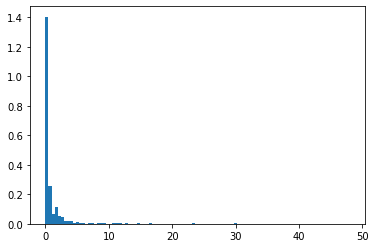

In [89]:
y_hat_all_int = []
ytest_int = []

j=0
for y_hat_i in y_hat_all:
  if y_hat_i != '-':
    y_hat_all_int.append(int(y_hat_i))
    ytest_int.append(int(ytest[j]))
  j = j + 1

y1 = np.array(y_hat_all_int)
y2 = np.array(ytest_int)

idx = y2 != 0
y1 = y1[idx]
y2 = y2[idx]

diff = np.abs((y1-y2)/y2)
print(f"mean relative error between predictions and labels = {np.mean(diff)}")
_ = plt.hist(diff,bins=100,density=True,)

## Conclusion

Hopefully, this second task has succeeded in demonstrating the value of pre-training and fine-tuning for text models, as well as using this simple use case as an introduction to the HuggingFace framework.

The pre-trained T5-small model, without any fine-tuning, was able to generate very good translations of highly domain-specific text data. In many scenarios, the translations generated by this model, though inexact, could have been used as-is.

In an effort to improve the results on our new dataset, we used part of the data to fine-tune the model which improved the results even more. Keep in mind, also, that we have severely limited the fine-tuning out of concern for execution time.
- We used only 9000 training sentences out of the millions of sentences that the dataset contains.
- We limited training time to a single epoch instead of training as long as the validation performance was improving.
- We used the default hyper-parameters (learning rate, etc.) and made no attempt to tune them.

This highlights the fact that fine-tuning could likely have improved performance a lot more if we had devoted more resources to it. Nonetheless, we were able to improve model performance quite a bit, proving that fine-tuning can be very useful even when very little data is available.

## References

**PatTR dataset :** Wäschle, Katharina, and Stefan Riezler. "Analyzing parallelism and domain similarities in the MAREC patent corpus." Information Retrieval Facility Conference. Springer, Berlin, Heidelberg, 2012. https://www.cl.uni-heidelberg.de/~riezler/publications/papers/IRF2012.pdf

**SacreBLEU :** Post, Matt. "A call for clarity in reporting BLEU scores." arXiv preprint arXiv:1804.08771 (2018). https://arxiv.org/abs/1804.08771

**HuggingFace :** https://huggingface.co/

**HuggingFace Transformers :** Wolf, Thomas, et al. "HuggingFace's Transformers: State-of-the-art Natural Language Processing." ArXiv (2019): arXiv-1910. https://arxiv.org/abs/1910.03771